In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.preprocessing import StandardScaler
from dtw import dtw

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import pandas as pd
import glob

# set paths to folders containing CSV files
path = "C:/DSGP/Data_Challenge_PHM2022_training_data/Data_Challenge_PHM2022_training_data/"

# combine data_po files into df1
files_po = glob.glob(path + "*data_po*.csv")
df1 = pd.DataFrame()
for file in files_po:
    with open(file, 'r') as f:
        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df1 = pd.concat([df1, temp_df], axis=0)

# rename the columns in df1 and convert to float
df1.columns = [i for i in range(df1.shape[1])]
df1 = df1.rename(columns={0: 'Fault'})
df1 = df1.astype(float)

# combine data_pdmp files into df2
files_pdmp = glob.glob(path + "*data_pdmp*.csv")
df2 = pd.DataFrame()
for file in files_pdmp:
    with open(file, 'r') as f:

        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df2 = pd.concat([df2, temp_df], axis=0)

# rename the columns in df2 and convert to float
df2.columns = [i for i in range(df2.shape[1])]
df2 = df2.rename(columns={0: 'Fault'})
df2 = df2.astype(float)

# combine data_pin files into df3
files_pin = glob.glob(path + "*data_pin*.csv")
df3 = pd.DataFrame()
for file in files_pin:
    with open(file, 'r') as f:

        csv_string = f.read()

        data = csv_string
        df = pd.DataFrame([x.split(',') for x in data.split('\n')])
        df.drop(df.tail(1).index,inplace=True)

        temp_df = df.iloc[:, :500]
        df3 = pd.concat([df3, temp_df], axis=0)

# rename the columns in df3 and convert to float
df3.columns = [i for i in range(df3.shape[1])]
df3 = df3.rename(columns={0: 'Fault'})
df3 = df3.astype(float)


In [3]:
# Assign Fault labels (true values) to new df y_true

y_true1 = df1["Fault"]
y_true2 = df2["Fault"]
y_true3 = df3["Fault"]

In [4]:
# del fault label column to get unlabelled df1, df2, df3

df1.columns = df1.columns.astype(str)
df1_un = df1.drop(df1.columns[0], axis=1)

df2.columns = df2.columns.astype(str)
df2_un = df2.drop(df2.columns[0], axis=1)

df3.columns = df3.columns.astype(str)
df3_un = df3.drop(df3.columns[0], axis=1)

# df1_un ... are unlabelled dfs

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pywt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [6]:
# Apply background noise removal using wavelet transform
def denoise(row):
    coeffs = pywt.wavedec(row, 'db4', level=6)
    coeffs[1:] = (pywt.threshold(i, value=0.5, mode='soft') for i in coeffs[1:])
    return pywt.waverec(coeffs, 'db4')

In [20]:
df1 = pd.DataFrame(np.apply_along_axis(denoise, 1, df1_un), index=df1_un.index)
df2 = pd.DataFrame(np.apply_along_axis(denoise, 1, df2_un), index=df2_un.index)
df3 = pd.DataFrame(np.apply_along_axis(denoise, 1, df3_un), index=df3_un.index)

In [21]:
# Scale the data using standard scaler
scaler = StandardScaler()
scaled_df1 = scaler.fit_transform(df1)
scaled_df2 = scaler.fit_transform(df2)
scaled_df3 = scaler.fit_transform(df3)

In [22]:
scaled_df1 = scaled_df1[:300, :500]
scaled_df2 = scaled_df2[:300, :500]
scaled_df3 = scaled_df3[:300, :500]

In [23]:
scaled_df1 = scaler.fit_transform(scaled_df1)
scaled_df2 = scaler.fit_transform(scaled_df2)
scaled_df3 = scaler.fit_transform(scaled_df3)

In [26]:
scaled_df1

array([[-0.28352668, -0.28607397, -0.28990596, ..., -2.18230349,
        -2.14624946, -2.13914701],
       [ 1.07052377,  1.10208652,  1.09788051, ...,  1.35345011,
         1.30076035,  1.19290877],
       [ 0.6357643 ,  0.55058238,  0.44468203, ...,  0.96322538,
         0.92426094,  0.87052327],
       ...,
       [-1.47724792, -1.36828596, -1.29464316, ..., -0.88282279,
        -0.88075496, -0.85754751],
       [ 1.77362779,  1.95018997,  2.12599148, ..., -0.44224608,
        -0.52696243, -0.62537258],
       [ 1.14278116,  1.21254733,  1.25378763, ...,  1.30509306,
         1.24996651,  1.14818075]])

In [28]:
# Perform DTW clustering on the rows
n_clusters = 11  # Number of clusters
km1 = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
km2 = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
km3 = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
km1.fit(scaled_df1)
km2.fit(scaled_df2)
km3.fit(scaled_df3)

TimeSeriesKMeans(metric='dtw', n_clusters=11)

In [29]:
scaled_df1 = pd.DataFrame(scaled_df1)
scaled_df2 = pd.DataFrame(scaled_df2)
scaled_df3 = pd.DataFrame(scaled_df3)

In [30]:
# Assign cluster labels to each row
scaled_df1['cluster'] = km1.labels_
scaled_df2['cluster'] = km2.labels_
scaled_df3['cluster'] = km3.labels_

In [33]:
scaled_df3


,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,cluster
0,-0.168525,-0.293249,-0.397417,-0.482497,-0.580929,-0.663389,-0.592548,-0.258886,0.458032,1.108811,...,-1.985073,-2.059784,-2.138896,-2.179990,-2.187108,-2.182035,-2.158887,-2.132248,-2.097740,7
1,-0.342877,-0.463028,-0.565716,-0.652534,-0.756686,-0.844688,-0.857348,-0.756417,-0.346740,0.298782,...,-1.066254,-0.898578,-0.685774,-0.515169,-0.415978,-0.341152,-0.320320,-0.284672,-0.228116,5
2,-0.238747,-0.269316,-0.293091,-0.304203,-0.316983,-0.315729,-0.130124,0.420346,1.338085,1.811749,...,-0.650000,-0.493122,-0.300427,-0.122418,0.020211,0.149842,0.245054,0.360376,0.503385,5
3,-0.698130,-0.485532,-0.370783,-0.352790,-0.266993,-0.150998,-0.243243,-0.640805,-1.295468,-1.550322,...,0.690145,0.675711,0.663641,0.651543,0.645956,0.646374,0.654130,0.668271,0.688120,10
4,1.336567,1.603365,1.657084,1.516731,1.458596,1.385588,1.246814,0.943558,0.011488,-1.111073,...,1.112030,1.067043,0.997944,0.921860,0.850819,0.777758,0.713466,0.627843,0.513947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.289900,-0.410442,-0.512296,-0.596840,-0.699675,-0.787616,-0.837337,-0.846316,-0.623952,-0.076681,...,-1.687092,-1.864659,-2.055265,-2.175180,-2.216349,-2.216365,-2.157768,-2.086335,-1.995668,4
296,2.771353,2.421781,2.100207,1.857465,1.396707,0.748892,0.273167,-0.336055,-1.175056,-1.391975,...,0.986064,0.976037,0.949553,0.927289,0.917587,0.910538,0.913999,0.905081,0.880624,0
297,2.154187,1.972663,1.684817,1.394450,0.956170,0.368523,-0.143638,-0.907421,-1.832545,-1.846650,...,1.115560,1.112063,1.107740,1.067925,1.002188,0.921658,0.825599,0.727037,0.619165,6
298,-1.433992,-1.446563,-1.488452,-1.556087,-1.617572,-1.645804,-1.764361,-2.029073,-1.981001,-1.060877,...,0.861054,0.869611,0.870762,0.873362,0.883479,0.895294,0.912627,0.925770,0.933099,3


In [34]:
y_true1 = y_true1[:300]
y_true2 = y_true2[:300]
y_true3 = y_true3[:300]

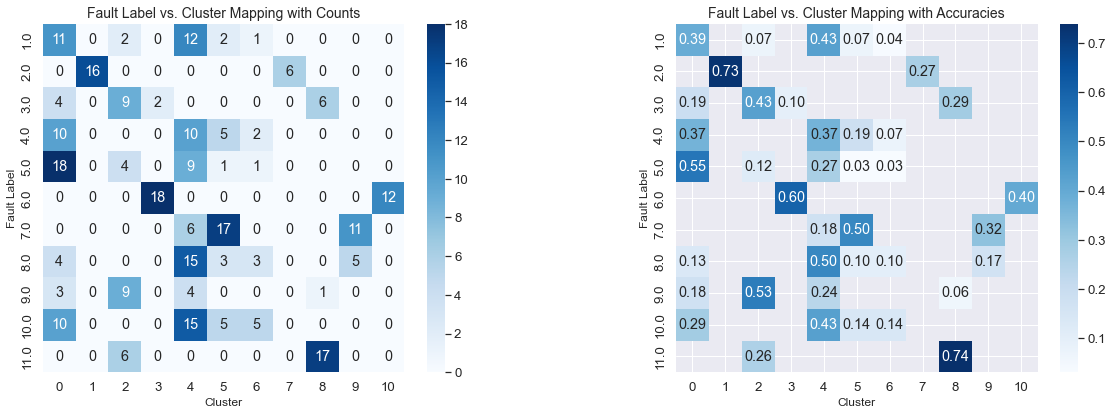

In [61]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true1, scaled_df1["cluster"])

# calculate the accuracy of each group
grouped = scaled_df1.groupby([y_true1, scaled_df1["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


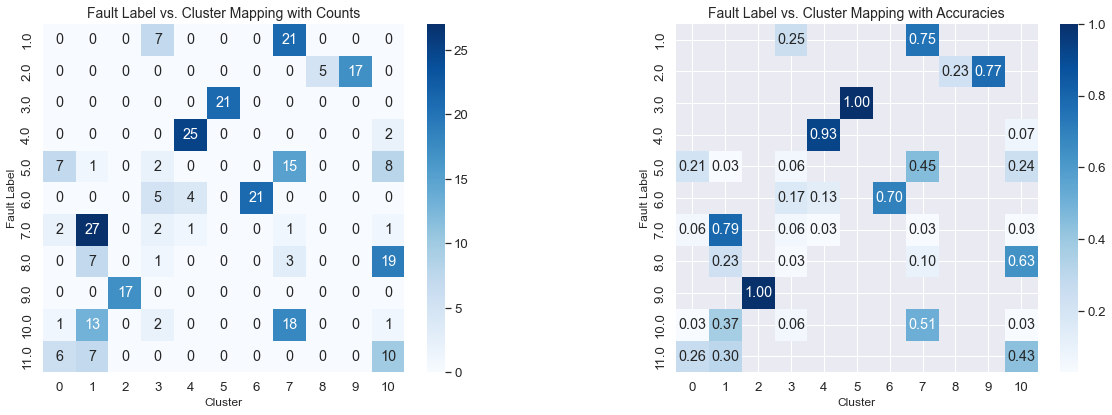

In [36]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true2, scaled_df2["cluster"])

# calculate the accuracy of each group
grouped = scaled_df2.groupby([y_true2, scaled_df2["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()


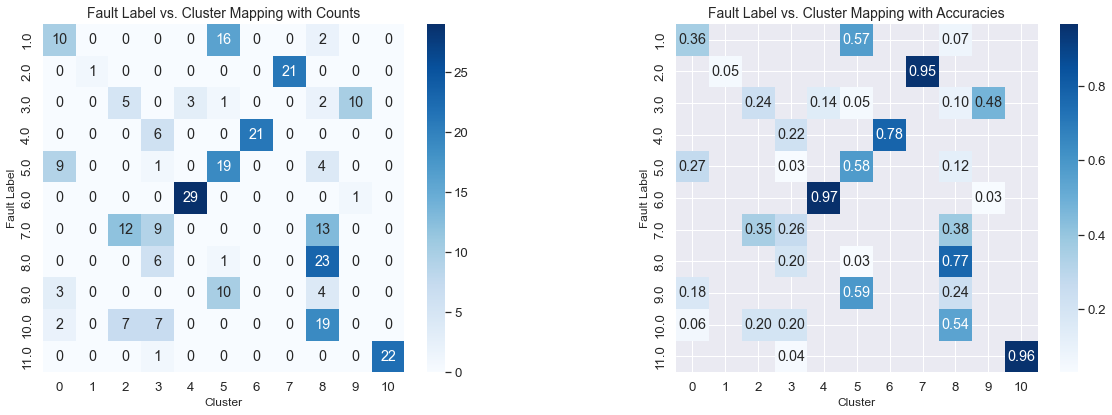

In [37]:
# create a crosstab of true labels and cluster assignments
label_cluster_map = pd.crosstab(y_true3, scaled_df3["cluster"])

# calculate the accuracy of each group
grouped = scaled_df3.groupby([y_true3, scaled_df3["cluster"]])
accuracy = grouped.size() / grouped.size().groupby(level=0).sum()

# create the figure and axes for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot the heatmap with counts on the left subplot
sns.set(font_scale=1.2)
sns.heatmap(label_cluster_map, cmap='Blues', annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel('Cluster', fontsize=12)
axs[0].set_ylabel('Fault Label', fontsize=12)
axs[0].set_title('Fault Label vs. Cluster Mapping with Counts', fontsize=14)

# plot the heatmap with accuracies on the right subplot
sns.heatmap(accuracy.unstack(), cmap='Blues', annot=True, fmt='.2f', ax=axs[1])
axs[1].set_xlabel('Cluster', fontsize=12)
axs[1].set_ylabel('Fault Label', fontsize=12)
axs[1].set_title('Fault Label vs. Cluster Mapping with Accuracies', fontsize=14)

# adjust the layout and spacing of the subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

# display the subplots
plt.show()
